### Full Code Until Now

epoch: 0, acc: 0.003, loss: 0.496 (data_loss: 0.496, reg_loss: 0.000), lr: 0.005
epoch: 100, acc: 0.017, loss: 0.048 (data_loss: 0.048, reg_loss: 0.000), lr: 0.004549590536851684
epoch: 200, acc: 0.242, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000), lr: 0.004170141784820684
epoch: 300, acc: 0.786, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.003849114703618168
epoch: 400, acc: 0.885, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0035739814152966403
epoch: 500, acc: 0.082, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.00333555703802535
epoch: 600, acc: 0.914, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0031269543464665416
epoch: 700, acc: 0.921, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.002942907592701589
epoch: 800, acc: 0.086, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0027793218454697055
epoch: 900, acc: 0.931, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0026329647182727752
epoch: 1000, acc: 0.936, loss: 0.0

epoch: 8300, acc: 0.979, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005376922249704269
epoch: 8400, acc: 0.974, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005319714863283328
epoch: 8500, acc: 0.980, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005263711969681019
epoch: 8600, acc: 0.978, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005208875924575476
epoch: 8700, acc: 0.980, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005155170636148056
epoch: 8800, acc: 0.979, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005102561485865905
epoch: 8900, acc: 0.981, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005051015254066068
epoch: 9000, acc: 0.982, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0005000500050005
epoch: 9100, acc: 0.901, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0004950985246063966
epoch: 9200, acc: 0.981, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.0004902441415825081
epo

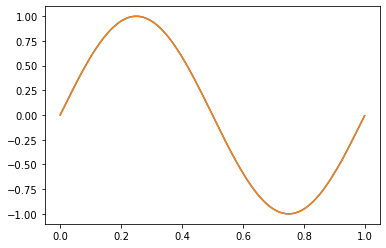

In [1]:
import numpy as np
import nnfs
from nnfs.datasets import sine_data

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs):
        # Save input values
        self.inputs = inputs
        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask

    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights * \
                                          layer.weights)


        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases * \
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Create dataset
X, y = sine_data()

# Create Dense layer with 1 input feature and 64 output values
dense1 = Layer_Dense(1, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 64 output values
dense2 = Layer_Dense(64, 64)

# Create ReLU activation (to be used with Dense layer):
activation2 = Activation_ReLU()

# Create third Dense layer with 64 input features (as we take output
# of previous layer here) and 1 output value
dense3 = Layer_Dense(64, 1)

# Create Linear activation:
activation3 = Activation_Linear()

# Create loss function
loss_function = Loss_MeanSquaredError()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)


# Accuracy precision for accuracy calculation
# There are no really accuracy factor for regression problem,
# but we can simulate/approximate it. We'll calculate it by checking
# how many values have a difference to their ground truth equivalent
# less than given precision
# We'll calculate this precision as a fraction of standard deviation
# of all the ground truth values
accuracy_precision = np.std(y) / 250

# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function
    # of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through activation function
    # takes the output of second dense layer here
    activation2.forward(dense2.output)

    # Perform a forward pass through third Dense layer
    # takes outputs of activation function of second layer as inputs
    dense3.forward(activation2.output)

    # Perform a forward pass through activation function
    # takes the output of third dense layer here
    activation3.forward(dense3.output)

    # Calculate the data loss
    data_loss = loss_function.calculate(activation3.output, y)

    # Calculate regularization penalty
    regularization_loss = \
        loss_function.regularization_loss(dense1) + \
        loss_function.regularization_loss(dense2) + \
        loss_function.regularization_loss(dense3)

    # Calculate overall loss
    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets
    # To calculate it we're taking absolute difference between
    # predictions and ground truth values and compare if differences
    # are lower than given precision value
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - y) <
                       accuracy_precision)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()


import matplotlib.pyplot as plt

X_test, y_test = sine_data()

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

plt.plot(X_test, y_test)
plt.plot(X_test, activation3.output)
plt.show()


### Model Object
Here, we will turn the model into an object for ease of use, cutting down on repeating code, and making saving and loading the model possible

In [2]:
class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)

The model can now be used as such

In [3]:
# instatiation of the model
model = Model()

# Add layers
model.add(Layer_Dense(1, 64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64, 64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64, 1))
model.add(Activation_Linear())

#### Optimizers

In [4]:
class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss and optimizer
    def set(self, *, loss, optimizer):
        # the * here indicates the following 
        # arguments are keyword arguments
        self.loss = loss
        self.optimizer = optimizer

In [5]:
# create dataset
X, y = sine_data()

# instatiation of the model
model = Model()

# Add layers
model.add(Layer_Dense(1, 64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64, 64))
model.add(Activation_ReLU())
model.add(Layer_Dense(64, 1))
model.add(Activation_Linear())

# set loss and optimizer objects
model.set(
    loss = Loss_MeanSquaredError(),
    optimizer = Optimizer_Adam(learning_rate = 0.005, decay = 1e-3)
)

#### Training
The crux here is that the layers stored in the array are the **hidden** layers, and the first layer doesn't have a previous layer. To solve this, the input "layer" will be used as the previous layer of the first hidden layer

In [7]:
class Layer_Input:
    
    # forward pass
    def forward(self, inpts):
        self.output = inputs

class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss and optimizer
    def set(self, *, loss, optimizer):
        # the * here indicates the following 
        # arguments are keyword arguments
        self.loss = loss
        self.optimizer = optimizer
        
    # finalize the model
    def finalize(self):
        
        # create and set the input layer
        self.input_layer = Layer_Input()
        
        # count all the objects
        layer_count = len(self.layers)
        
        # iterate the objects
        for i in range(layer_count):
            
            # if it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            # all layers except for the first and last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            
            # the last layer - the next object is the loss
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
    
    # performs a forward pass
    def forward(self, X):
        
        self.input_layer.forward(X)
        
        for layer in self.layers:
            layer.forward(layer.prev.output)
            
        # variable "layer" is now the last object in the list
        # return its output
        return layer.output
                
        
    # train the model
    def train(self, X, y, *, epochs = 1, print_every = 1):
        
        # main training loop
        for epoch in range(1, epochs + 1):
            
            # perform the forward pass
            output = self.forward(X)
            
            pass

Before the the actual training, the model needs to know which layers are "trainable"

In [8]:
class Layer_Input:
    
    # forward pass
    def forward(self, inpts):
        self.output = inputs

class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss and optimizer
    def set(self, *, loss, optimizer):
        # the * here indicates the following 
        # arguments are keyword arguments
        self.loss = loss
        self.optimizer = optimizer
        
    # finalize the model
    def finalize(self):
        
        # create and set the input layer
        self.input_layer = Layer_Input()
        
        # count all the objects
        layer_count = len(self.layers)
        
        # initializing the list of trainable layers
        self.trainable_layers = []
        
        # iterate the objects
        for i in range(layer_count):
            
            # if it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            # all layers except for the first and last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            
            # the last layer - the next object is the loss
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            
            # if layer contains an attribute called "weights",
            # it's a trainable layer;
            # add it to the list of trainable layers
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
    
    # performs a forward pass
    def forward(self, X):
        
        self.input_layer.forward(X)
        
        for layer in self.layers:
            layer.forward(layer.prev.output)
            
        # variable "layer" is now the last object in the list
        # return its output
        return layer.output
                
        
    # train the model
    def train(self, X, y, *, epochs = 1, print_every = 1):
        
        # main training loop
        for epoch in range(1, epochs + 1):
            
            # perform the forward pass
            output = self.forward(X)
            
            pass

The Loss class also needs the following update, so the regularization penalty can be looped over, rather than being calculated one at a time:

In [9]:
# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0
        
        # calculate the penalty by iterating over all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights * \
                                              layer.weights)


            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases * \
                                              layer.biases)

        return regularization_loss

    # set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
        
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss, self.regularization_loss()
    

For calculating accuracy, predictions is needed, and accuracy is calculated differently, depending on the type of model

The predictions (the accuracy) will now be baked into the activation functions

In [10]:
# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities
        
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    def predictions(self, outputs):
        return (outputs > 0.5) * 1

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs):
        # Just remember values
        self.inputs = inputs
        self.output = inputs
        
    def predictions(self, outputs):
        return outputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

And the model needs to be able to find this prediction function easily:

In [11]:
class Layer_Input:
    
    # forward pass
    def forward(self, inpts):
        self.output = inputs

class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss and optimizer
    def set(self, *, loss, optimizer):
        # the * here indicates the following 
        # arguments are keyword arguments
        self.loss = loss
        self.optimizer = optimizer
        
    # finalize the model
    def finalize(self):
        
        # create and set the input layer
        self.input_layer = Layer_Input()
        
        # count all the objects
        layer_count = len(self.layers)
        
        # initializing the list of trainable layers
        self.trainable_layers = []
        
        # iterate the objects
        for i in range(layer_count):
            
            # if it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            # all layers except for the first and last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            
            # the last layer - the next object is the loss
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            
            # if layer contains an attribute called "weights",
            # it's a trainable layer;
            # add it to the list of trainable layers
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
    
    # performs a forward pass
    def forward(self, X):
        
        self.input_layer.forward(X)
        
        for layer in self.layers:
            layer.forward(layer.prev.output)
            
        # variable "layer" is now the last object in the list
        # return its output
        return layer.output
                
        
    # train the model
    def train(self, X, y, *, epochs = 1, print_every = 1):
        
        # main training loop
        for epoch in range(1, epochs + 1):
            
            # perform the forward pass
            output = self.forward(X)
            
            pass

In [13]:
# common accuracy class
class Accuracy:
    
    # calculates an accuracy given predictions and ground truth values
    def calculate(self, predictions, y):
        
        # get comparison restults
        comparisons = self.compare(predictions, y)
        
        # calculate an accuracy
        accuracy = np.mean(comparisons)
        
        # return accuracy
        return accuracy
    
# accuracy calculation for regression model
class Accuracy_Regression(Accuracy):
    
    def __init__(self):
        # create precision property
        self.precision = None
        
    # recalculates precision value
    # based on passed in ground truth
    def init(self, y, reinit = False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250
            
    # compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

Now the model class needs the accuracy being set

In [14]:
class Model:
    
    def __init__(self):
        # create a list of network objects
        self.layers = []
        
    # add objects to the model
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss and optimizer
    def set(self, *, loss, optimizer, accuracy):
        # the * here indicates the following 
        # arguments are keyword arguments
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        
    # finalize the model
    def finalize(self):
        
        # create and set the input layer
        self.input_layer = Layer_Input()
        
        # count all the objects
        layer_count = len(self.layers)
        
        # initializing the list of trainable layers
        self.trainable_layers = []
        
        # iterate the objects
        for i in range(layer_count):
            
            # if it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            # all layers except for the first and last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            
            # the last layer - the next object is the loss
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            
            # if layer contains an attribute called "weights",
            # it's a trainable layer;
            # add it to the list of trainable layers
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        
        # update loss object with trainable layers
        self.loss.remember_trainable_layers(
            self.trainable_layers
        )
    
    # performs a forward pass
    def forward(self, X):
        
        self.input_layer.forward(X)
        
        for layer in self.layers:
            layer.forward(layer.prev.output)
            
        # variable "layer" is now the last object in the list
        # return its output
        return layer.output
                
        
    # train the model
    def train(self, X, y, *, epochs = 1, print_every = 1):
        
        # initialize accuracy object
        self.accuracy.init(y)
        
        # main training loop
        for epoch in range(1, epochs + 1):
            
            # perform the forward pass
            output = self.forward(X)
            
            # calculate loss
            data_loss, regularization_loss = \
                self.loss.calculate(output, y)
            loss = data_loss + regularization_loss
            
            # get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                                output)
            accuracy = self.accuracy.calculate(predictions, y)
            

### Full Code Until Now

In [15]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()


# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# Dropout
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask


    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask


# Input "layer"
class Layer_Input:

    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)


# Sigmoid activation
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs, training):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return (outputs > 0.5) * 1


# Linear activation
class Activation_Linear:

    # Forward pass
    def forward(self, inputs, training):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)
            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))


    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights *
                                              layer.weights)

            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases *
                                              layer.biases)

        return regularization_loss

    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers


    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Binary cross-entropy loss
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Squared Error loss
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Mean Absolute Error loss
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Common accuracy class
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Return accuracy
        return accuracy


# Accuracy calculation for classification model
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y


# Accuracy calculation for regression model
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250


    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision


# Model class
class Model:

    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)

    # Set loss, optimizer and accuracy
    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy

    # Finalize the model
    def finalize(self):

        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])

        # Update loss object with trainable layers
        self.loss.remember_trainable_layers(
            self.trainable_layers
        )

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()

    # Train the model
    def train(self, X, y, *, epochs=1, print_every=1,
              validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        # Main training loop
        for epoch in range(1, epochs+1):

            # Perform the forward pass
            output = self.forward(X, training=True)


            # Calculate loss
            data_loss, regularization_loss = \
                self.loss.calculate(output, y,
                                    include_regularization=True)
            loss = data_loss + regularization_loss

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            accuracy = self.accuracy.calculate(predictions, y)

            # Perform backward pass
            self.backward(output, y)

            # Optimize (update parameters)
            self.optimizer.pre_update_params()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

            # Print a summary
            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                      f'acc: {accuracy:.3f}, ' +
                      f'loss: {loss:.3f} (' +
                      f'data_loss: {data_loss:.3f}, ' +
                      f'reg_loss: {regularization_loss:.3f}), ' +
                      f'lr: {self.optimizer.current_learning_rate}')

        # If there is the validation data
        if validation_data is not None:

            # For better readability
            X_val, y_val = validation_data

            # Perform the forward pass
            output = self.forward(X_val, training=False)

            # Calculate the loss
            loss = self.loss.calculate(output, y_val)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            accuracy = self.accuracy.calculate(predictions, y_val)


            # Print a summary
            print(f'validation, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {loss:.3f}')

    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output

    # Performs backward pass
    def backward(self, output, y):

        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return


        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)


# Create dataset
X, y = spiral_data(samples=1000, classes=3)
X_test, y_test = spiral_data(samples=100, classes=3)

# Instantiate the model
model = Model()

# Add layers
model.add(Layer_Dense(2, 512, weight_regularizer_l2=5e-4,
                              bias_regularizer_l2=5e-4))
model.add(Activation_ReLU())
model.add(Layer_Dropout(0.1))
model.add(Layer_Dense(512, 3))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(learning_rate=0.05, decay=5e-5),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test),
            epochs=10000, print_every=100)


epoch: 100, acc: 0.720, loss: 0.719 (data_loss: 0.658, reg_loss: 0.061), lr: 0.04975371909050202
epoch: 200, acc: 0.788, loss: 0.609 (data_loss: 0.530, reg_loss: 0.079), lr: 0.049507401356502806
epoch: 300, acc: 0.796, loss: 0.594 (data_loss: 0.513, reg_loss: 0.080), lr: 0.0492635105177595
epoch: 400, acc: 0.831, loss: 0.536 (data_loss: 0.456, reg_loss: 0.080), lr: 0.04902201088288642
epoch: 500, acc: 0.823, loss: 0.528 (data_loss: 0.447, reg_loss: 0.082), lr: 0.048782867456949125
epoch: 600, acc: 0.830, loss: 0.515 (data_loss: 0.438, reg_loss: 0.077), lr: 0.04854604592455945
epoch: 700, acc: 0.822, loss: 0.560 (data_loss: 0.486, reg_loss: 0.074), lr: 0.048311512633460556
epoch: 800, acc: 0.847, loss: 0.478 (data_loss: 0.403, reg_loss: 0.075), lr: 0.04807923457858551
epoch: 900, acc: 0.840, loss: 0.506 (data_loss: 0.435, reg_loss: 0.070), lr: 0.04784917938657352
epoch: 1000, acc: 0.845, loss: 0.476 (data_loss: 0.405, reg_loss: 0.071), lr: 0.04762131530072861
epoch: 1100, acc: 0.850, lo

epoch: 8500, acc: 0.860, loss: 0.433 (data_loss: 0.377, reg_loss: 0.055), lr: 0.035088950489490865
epoch: 8600, acc: 0.864, loss: 0.419 (data_loss: 0.367, reg_loss: 0.052), lr: 0.0349662575614532
epoch: 8700, acc: 0.872, loss: 0.428 (data_loss: 0.378, reg_loss: 0.050), lr: 0.034844419666190465
epoch: 8800, acc: 0.860, loss: 0.428 (data_loss: 0.378, reg_loss: 0.050), lr: 0.034723427896801974
epoch: 8900, acc: 0.849, loss: 0.446 (data_loss: 0.397, reg_loss: 0.048), lr: 0.03460327346967023
epoch: 9000, acc: 0.856, loss: 0.459 (data_loss: 0.403, reg_loss: 0.056), lr: 0.034483947722335255
epoch: 9100, acc: 0.866, loss: 0.438 (data_loss: 0.383, reg_loss: 0.054), lr: 0.034365442111412764
epoch: 9200, acc: 0.858, loss: 0.454 (data_loss: 0.401, reg_loss: 0.053), lr: 0.03424774821055516
epoch: 9300, acc: 0.853, loss: 0.437 (data_loss: 0.387, reg_loss: 0.050), lr: 0.03413085770845422
epoch: 9400, acc: 0.847, loss: 0.445 (data_loss: 0.396, reg_loss: 0.049), lr: 0.034014762406884586
epoch: 9500, ac